In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import jax.numpy as jnp
import jax.random as jr
from ABC import abc_smc
from parameters import sample_prior, initialize, to_train_array
from ssm import LGSSM
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore

from matplotlib import pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

In [2]:
num_timesteps = 30
num_rounds = 5
# SSM model parameters
state_dim = 1
emission_dim = 1
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 0.1

dynamics_weights  = 0.9 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.1

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 0.1

# Initialize props and prior
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=0.1*jnp.ones(m))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov']]
prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_weights, emission_bias, emission_input_weights, emission_covariance]]
is_constrained_tree = [[True, True], 
                       [True, True, True, False], 
                       [True, True, True, True]]
constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector]]

props_prior = initialize(prior_fields, param_names, constrainers)

seed = 121241278123  
key = jr.PRNGKey(seed)  

key, subkey = jr.split(key)
lgssm = LGSSM(state_dim, emission_dim)
params_sample = sample_prior(subkey, props, 10)
true_param = params_sample[0]
example_param = params_sample[1]
true_param_vec = to_train_array(true_param, props)
true_param.from_unconstrained(props)
key, subkey = jr.split(key)
states, observations = lgssm.simulate(subkey, true_param, num_timesteps)

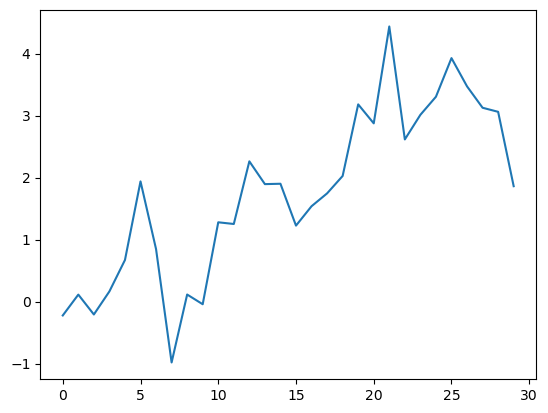

In [3]:
plt.plot(observations)
plt.show()

In [4]:
out = abc_smc(key, observations, lgssm, props, 1000, eps_fin = 1.1)

set eps to 9.0
set eps to 8.09999942779541


set eps to 7.289999485015869
set eps to 6.560999393463135
set eps to 5.9048991203308105
set eps to 5.314409255981445
set eps to 4.782968044281006
set eps to 4.304671287536621
set eps to 3.874204158782959
set eps to 3.486783742904663
set eps to 3.1381053924560547
set eps to 2.8242948055267334
set eps to 2.541865348815918
set eps to 2.2876787185668945
set eps to 2.058910846710205
set eps to 1.8530197143554688
set eps to 1.667717695236206
set eps to 1.5009459257125854
set eps to 1.35085129737854
set eps to 1.215766191482544
set eps to 1.0941895246505737


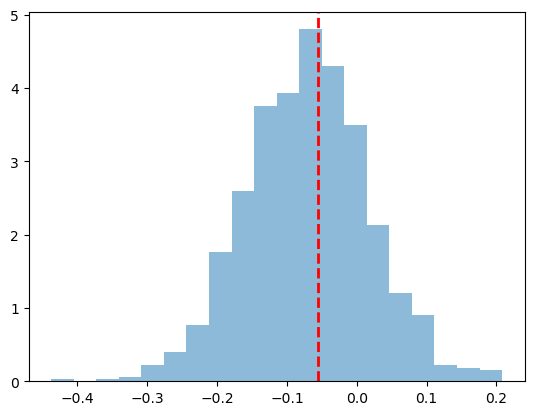

In [5]:
plt.hist(out[0][:, 0], bins=20, alpha=0.5, label='Posterior', density=True)
plt.axvline(x=true_param_vec, color='r', linestyle='dashed', linewidth=2)
plt.show()

## Tolerance schedule selection

- There are a few ways to select the tolerance (check ABC_tolerance paper). The one that is implemented at the moment is based on quantiles (select eps to be a quantile of the accept distances of the previous round, this seems to be popular in the lit)
- There are also the considerations that I have been doing in the Notion. The code below explores these. (they are based on the idea of average sq. distance of samples from the true posterior, and how this information can help us to select the tolerance. Note that this approach assumes that the observed value comes from the bulk of the posterior, which is not always the case. But it is a good starting point)

In [ ]:
num_params = 1000
num_emissions_per_param = 1000
params_sample = sample_prior(key, props_prior, num_params)
sq_dist = lambda x, y: jnp.linalg.norm(x - y) / jnp.sqrt(num_timesteps * emission_dim)
simulator = lambda key, ps: true_lgssm.simulate(key, ps, num_timesteps)[1]

def I_hat(key, ps, num_emissions):
    all_emissions = vmap(simulator, in_axes=(0,None))(jr.split(key, num_emissions), ps)
    sq_distances = vmap(lambda x: vmap(sq_dist, in_axes=(None,0))(x, all_emissions))(all_emissions)
    return sq_distances.mean()

for param in params_sample:
    key, subkey = jr.split(key)
    param.from_unconstrained(props_prior)

I_hat_js = jnp.array(list(map(I_hat, jr.split(key, num_params), params_sample, [num_emissions_per_param] * num_params)))

plt.hist(jnp.sqrt(I_hat_js), bins=25)
plt.show()